In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
"""data = pd.read_csv('/content/drive/MyDrive/ANN/Datasets/YearPredictionMSD.txt', header=None)
data = data.sample(frac = 1).reset_index(drop=True)
data.to_csv('/content/drive/MyDrive/ANN/Datasets/shuffled.csv', header=False, index = False)"""

"data = pd.read_csv('/content/drive/MyDrive/ANN/Datasets/YearPredictionMSD.txt', header=None)\ndata = data.sample(frac = 1).reset_index(drop=True)\ndata.to_csv('/content/drive/MyDrive/ANN/Datasets/shuffled.csv', header=False, index = False)"

In [3]:
data = pd.read_csv('/content/drive/MyDrive/ANN/Datasets/shuffled.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2007,47.85716,-22.54866,27.41759,-3.46676,12.55414,-10.22042,-9.18490,-7.13421,-9.53504,-5.93245,0.57714,-4.70568,61.66049,2867.48999,1944.08552,1784.42263,1207.38170,664.43034,577.79656,549.58769,456.81456,300.43874,246.92914,266.58839,223.80406,-863.28995,-74.21058,-76.36981,-65.16386,64.81949,-31.21618,7.72559,-15.13828,-64.63773,-13.14384,38.33320,-252.53327,-278.20472,-422.52063,...,26.36727,-18.91126,1.98145,25.16795,-149.99879,-50.90433,41.11608,8.05801,-210.68600,-42.75290,35.18520,-17.60934,13.65030,-338.55109,-30.58494,35.76208,11.35889,59.26721,86.69136,-19.56605,-139.79139,10.21379,0.14924,-34.07940,-51.48116,-46.05088,36.88103,20.17341,-171.02320,14.09129,37.80966,-158.87348,169.06257,59.61731,-2.20260,82.48771,-164.05115,9.64560,134.01159,10.97408
1,2003,52.08312,22.22323,19.70803,-6.34980,-22.01613,-23.59558,-4.43211,-5.20110,4.66203,3.11451,1.36996,1.41865,10.61272,1683.98949,750.69069,689.95647,581.29657,291.23380,283.81821,323.20547,279.78425,155.57909,167.29504,124.75346,41.95109,9.03560,-87.31790,-25.05778,-120.50192,6.26263,-23.86149,3.67036,12.61330,3.68605,-1.20386,-5.03250,-244.50791,-174.65006,-16.73915,...,36.12745,9.46506,-30.00579,26.49068,25.44980,-135.68219,24.69577,33.52959,1.27662,-85.21346,-29.57517,1.60170,-15.29097,-19.32349,-71.14568,42.22941,26.16730,14.61289,-19.89144,-2.31856,110.67443,76.66515,-15.62666,39.84537,-23.63016,8.16260,-60.59498,1.75061,-86.04602,34.42540,-10.07294,-7.06261,12.42736,39.77289,-0.41058,45.56069,48.57920,1.15398,64.40024,0.55140
2,2005,48.21072,-15.91816,2.07506,-13.89081,-4.34230,-15.00750,-11.66430,-9.04179,-0.18506,-8.89775,0.92205,12.65308,13.66445,1367.46906,624.89184,549.96749,451.94673,430.00000,370.69808,381.46521,309.08273,267.60033,133.98007,145.65567,47.79475,-237.57732,-79.39043,-19.00565,-55.21383,-3.16614,9.97518,0.36305,-22.70285,-41.40037,-6.87967,1.18909,-37.30190,-159.06320,-160.83604,...,22.64237,-58.49335,17.13903,3.30279,-0.64256,-54.53288,-47.29670,-116.28927,19.09955,-117.79150,-11.41164,-3.75067,-9.60609,-94.54838,6.55066,-12.86156,-13.46065,13.26680,34.09207,-11.55161,-109.55424,-20.87600,0.00377,-10.89014,-14.02785,-9.91583,184.98336,48.14045,-26.09251,5.60701,21.40159,-77.70125,8.67284,13.78993,4.16783,68.44852,-29.81270,4.65790,18.11617,1.87273
3,1982,37.23893,-61.57292,-8.41641,3.53303,-68.31349,4.12890,23.19388,0.57733,15.38495,-10.38546,4.05766,1.14463,26.52685,2025.06370,1954.59923,1183.20386,736.35195,705.35929,622.80910,392.36940,795.25798,410.57707,263.77880,292.14555,24.01719,380.65116,-645.27885,69.82662,-47.58921,33.14936,36.02033,5.85842,217.78312,-26.98982,-39.91616,30.04096,115.82088,-229.66297,-263.33341,...,66.50618,-193.93881,-13.73458,233.81607,-76.70293,2.76503,-86.71281,-67.09139,-32.43151,-113.89672,23.15733,-5.20699,28.66754,-526.18576,39.66235,-116.00312,-23.95451,26.51531,-133.47617,-61.43846,76.67006,284.78975,-67.73264,24.40962,-35.31231,-23.29012,630.24578,288.99653,54.73015,2.22204,82.27618,263.81035,-182.75213,-64.27024,13.62364,33.17791,107.14478,7.05733,240.23404,26.53820
4,2004,51.26551,11.37543,27.89572,0.44384,-11.08988,-20.47332,9.17345,-0.84317,3.19313,6.24197,-0.98135,-0.36932,10.40483,915.88236,1145.10263,486.84712,1048.51097,428.96277,420.32199,312.18948,258.36617,188.41523,175.19580,291.55670,-9.12916,95.24901,122.83992,180.79745,10.73693,48.69879,-2.70455,-6.76961,21.97340,-16.65634,54.78426,13.37456,-100.25554,423.67127,-113.89452,...,-50.31355,98.49313,-16.52861,-29.66221,-22.05528,-62.18155,84.55146,49.12364,6.13112,-11.46305,-52.60162,0.21349,-10.88931,-116.70456,-38.56895,45.48205,29.25824,27.11312,-73.54797,14.81368,-21.19950,116.54460,-0.09501,-7.28943,44.92769,5.01606,-126.21246,30.93915,-33.59216,-90.89191,0.32462,-93.78731,18.71632,-6.71576,5.38048,104.2

In [4]:
xdata = data.drop(columns=0)
ydata = data.loc[:,0]
scaler = StandardScaler()
xdata = pd.DataFrame(scaler.fit_transform(xdata))
xdata.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89
0,0.736711,-0.462157,0.531897,-0.283707,0.835831,-0.054321,-0.466228,-0.670655,-1.253246,-1.196717,0.165567,-0.871585,1.255479,0.244735,-0.018747,0.246665,0.623072,-0.372212,-0.081704,0.103465,0.293684,-0.152653,-0.224411,-0.165400,1.488701,-1.266635,-0.050950,-0.223004,-0.490899,0.150530,-0.366825,-0.227110,-0.331092,-1.129714,-0.321092,-0.318027,-0.484514,-0.873681,-0.892554,-0.234043,...,0.213657,-0.628992,-0.154194,0.281795,-2.418302,-0.419994,-0.204754,0.030305,-1.474899,-0.102461,0.536333,-0.364294,0.375023,-0.650020,-0.134514,0.277191,0.082136,0.270999,0.515882,-0.508982,-0.520097,0.023420,0.167887,-0.349834,-0.462333,-1.535566,0.224413,-0.075887,-0.328375,-0.103927,0.687057,-0.486349,1.043292,0.228123,-0.155822,0.566458,-0.791689,0.388637,0.614236,0.436650
1,1.433196,0.405846,0.313301,-0.460334,-0.676379,-1.094563,-0.140066,-0.427918,0.088271,0.188680,0.346955,-0.135503,-1.037812,-0.431796,-0.964772,-0.754832,-0.693041,-1.019151,-1.007623,-0.628301,-0.533509,-1.026885,-0.650351,-1.089554,-0.008901,-0.047892,-0.075005,0.011975,-0.829948,-0.283586,-0.292601,-0.283581,0.041855,0.146961,-0.040088,-0.719886,-0.465177,-0.645284,0.664282,-0.295917,...,0.317981,-0.250889,-0.611274,0.297678,0.616798,-0.729598,-0.257529,0.125785,-0.221216,-0.397157,-0.553044,0.026322,-0.393152,0.385804,-0.317057,0.327662,0.230338,-0.111656,-0.486214,-0.040289,0.475369,0.313524,0.071564,0.818220,-0.031813,0.521235,-0.139045,-0.203685,0.094109,0.060260,-0.804631,0.378085,-0.238202,0.019345,-0.044941,0.243747,0.430485,-0.247604,0.239090,-0.035209
2,0.794982,-0.333610,-0.186662,-0.922327,0.096729,-0.426632,-0.636378,-0.910186,-0.369743,-1.650806,0.244478,1.214759,-0.900715,-0.612731,-1.064495,-0.882930,-0.964951,-0.778599,-0.733985,-0.439980,-0.396608,-0.350834,-0.828544,-0.953361,0.039223,-0.392440,-0.060456,0.039690,-0.429936,-0.353487,0.048880,-0.329638,-0.432751,-0.695508,-0.173666,-0.662232,0.034068,-0.610906,0.111434,0.419564,...,0.173842,-1.156407,0.062399,0.019240,0.165424,-0.433245,-0.488916,-0.435810,-0.115800,-0.623263,-0.247504,-0.082507,-0.242261,0.141715,0.032614,-0.102264,-0.166256,-0.123191,0.021341,-0.291193,-0.399921,-0.112308,0.166998,0.016569,0.116619,-0.164641,0.776640,0.118118,0.392181,-0.172433,0.175896,-0.024142,-0.268919,-0.254014,0.238345,0.443767,-0.020102,0.014930,-0.010342,0.024611
3,-1.013291,-1.218730,-0.484135,0.145129,-2.701567,1.061686,1.755779,0.297667,1.101506,-1.878625,0.961871,-0.168438,-0.322879,-0.236826,-0.010412,-0.303484,-0.367094,-0.301262,0.060068,-0.404733,1.875097,0.512036,-0.134287,0.001123,-0.156591,0.471299,-1.099014,0.446491,-0.383221,-0.084259,0.311728,-0.253111,2.799084,-0.426238,-0.951172,-0.394869,0.403004,-0.766619,-0.281810,0.304661,...,0.642695,-2.961163,-0.378767,2.787218,-1.150350,-0.223996,-0.615601,-0.251392,-0.420587,-0.596231,0.334004,-0.112118,0.773618,-1.258854,0.181632,-0.907171,-0.271277,-0.009661,-1.554143,-1.646845,0.340220,1.222126,-0.246577,0.574326,-0.212395,-0.672047,2.436886,1.788919,0.794009,-0.199764,2.072324,1.920478,-1.835040,-1.075263,0.823419,0.135533,0.767113,0.194709,1.186685,1.141274
4,1.298445,0.195537,0.545454,-0.044128,-0.198431,-0.851732,0.793621,0.119298,-0.050529,0.667601,-0.190998,-0.350399,-1.047151,-0.870874,-0.652114,-0.940689,0.289105,-0.780397,-0.577688,-0.663909,-0.633587,-0.828718,-0.608092,-0.002714,-0.429559,0.072558,0.310691,0.954673,-0.025865,0.031018,-0.079085,-0.428965,0.167643,-0.233150,1.277579,-0.549313,-0.117614,0.674352,0.291532,-0.264252,...,-0.605972,0.935374,-0.418693,-0.376600,-0.204996,-0.461177,-0.065151,0.184239,-0.192503,0.114704,-0.940388,-0.001904,-0.276321,0.069823,-0.170446,0.353045,0.261272,-0.004538,-0.990696,0.425271,-0.048758,0.487624,0.166395,0.073463,1.027953,0.401859,-0.383713,-0.001206,0.3548

In [5]:
x_train = xdata.loc[:round(0.7*data.shape[0]),:]
y_train = ydata.loc[:round(0.7*data.shape[0])]
x_val = xdata.loc[round(0.7*data.shape[0]):int(0.9*data.shape[0]),:]
y_val = ydata.loc[round(0.7*data.shape[0]):int(0.9*data.shape[0])]
x_test = xdata.loc[round(0.9*data.shape[0]):,:]
y_test = ydata.loc[round(0.9*data.shape[0]):]

print('Dataset Shapes:\n',x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)

Dataset Shapes:
 (360743, 90) (360743,) (103069, 90) (103069,) (51535, 90) (51535,)


In [6]:
y_train = tf.keras.utils.to_categorical(y_train-1922, 90)
y_val = tf.keras.utils.to_categorical(y_val-1922, 90)
y_test = tf.keras.utils.to_categorical(y_test-1922, 90)

In [7]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
  def __init__(self, patience=0):
    super(EarlyStoppingCallback, self).__init__()
    self.patience = patience

  def on_train_begin(self, logs=None):
    self.best = -np.Inf
    self.wait = 0
    self.stopped_epoch = 0

  def on_epoch_end(self, epoch, logs=None):
    current_accuracy = logs.get("val_accuracy")
    if np.greater(current_accuracy, self.best):
      self.best = current_accuracy
      self.wait = 0
      self.best_weights = self.model.get_weights()
    else:
      self.wait += 1
      if self.wait >= self.patience:
        self.stopped_epoch = epoch
        self.model.stop_training = True
        self.model.set_weights(self.best_weights)

  def on_train_end(self, logs=None):
    if self.stopped_epoch > 0:
      print("epoch: %d: early stopping" % self.stopped_epoch)

In [8]:
def adapt_learning_rate(epoch):
    if epoch>5:
      return 0.0005 / (epoch-4)
    else:
      return 0.0005
  
my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [9]:
tf.keras.backend.clear_session()

cls_callback = EarlyStoppingCallback(patience=5)

inp = tf.keras.Input(shape = 90, name="input")
hidden = tf.keras.layers.Dense(128, activation='relu')(inp)
hidden = tf.keras.layers.Dense(512, activation='relu')(hidden)
#hidden = tf.keras.layers.Dense(64, activation='relu')(hidden)
outp = tf.keras.layers.Dense(90, activation='softmax')(hidden)

model = tf.keras.Model(inputs=inp, outputs=outp)

In [10]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=1000, verbose=1, validation_data=(x_val,y_val), callbacks=[cls_callback, my_lr_scheduler])

Epoch 1/1000
11274/11274 [==============================] - 39s 3ms/step - loss: 3.2387 - accuracy: 0.0822 - val_loss: 3.0967 - val_accuracy: 0.0942
Epoch 2/1000
11274/11274 [==============================] - 37s 3ms/step - loss: 3.0685 - accuracy: 0.1013 - val_loss: 3.0662 - val_accuracy: 0.1009
Epoch 3/1000
11274/11274 [==============================] - 38s 3ms/step - loss: 3.0278 - accuracy: 0.1076 - val_loss: 3.0581 - val_accuracy: 0.1037
Epoch 4/1000
11274/11274 [==============================] - 38s 3ms/step - loss: 2.9942 - accuracy: 0.1159 - val_loss: 3.0564 - val_accuracy: 0.1050
Epoch 5/1000
11274/11274 [==============================] - 38s 3ms/step - loss: 2.9748 - accuracy: 0.1203 - val_loss: 3.0573 - val_accuracy: 0.1069
Epoch 6/1000
11274/11274 [==============================] - 38s 3ms/step - loss: 2.9539 - accuracy: 0.1273 - val_loss: 3.0601 - val_accuracy: 0.1070
Epoch 7/1000
11274/11274 [==============================] - 38s 3ms/step - loss: 2.9084 - accuracy: 0.1387

In [18]:
test_pred = np.argmax(model.predict(x_test), axis=-1)+1922
confmat = confusion_matrix(ydata.loc[round(0.9*data.shape[0]):], test_pred, np.arange(1922,2012))
print(confmat)
print(confmat.shape)
df_confmat = pd.DataFrame(confmat, index = [i for i in np.arange(1922,2012)], columns = [i for i in np.arange(1922,2012)])

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 539   7   0]
 [  0   0   0 ... 169   1   0]
 [  0   0   0 ...   0   0   0]]
(90, 90)


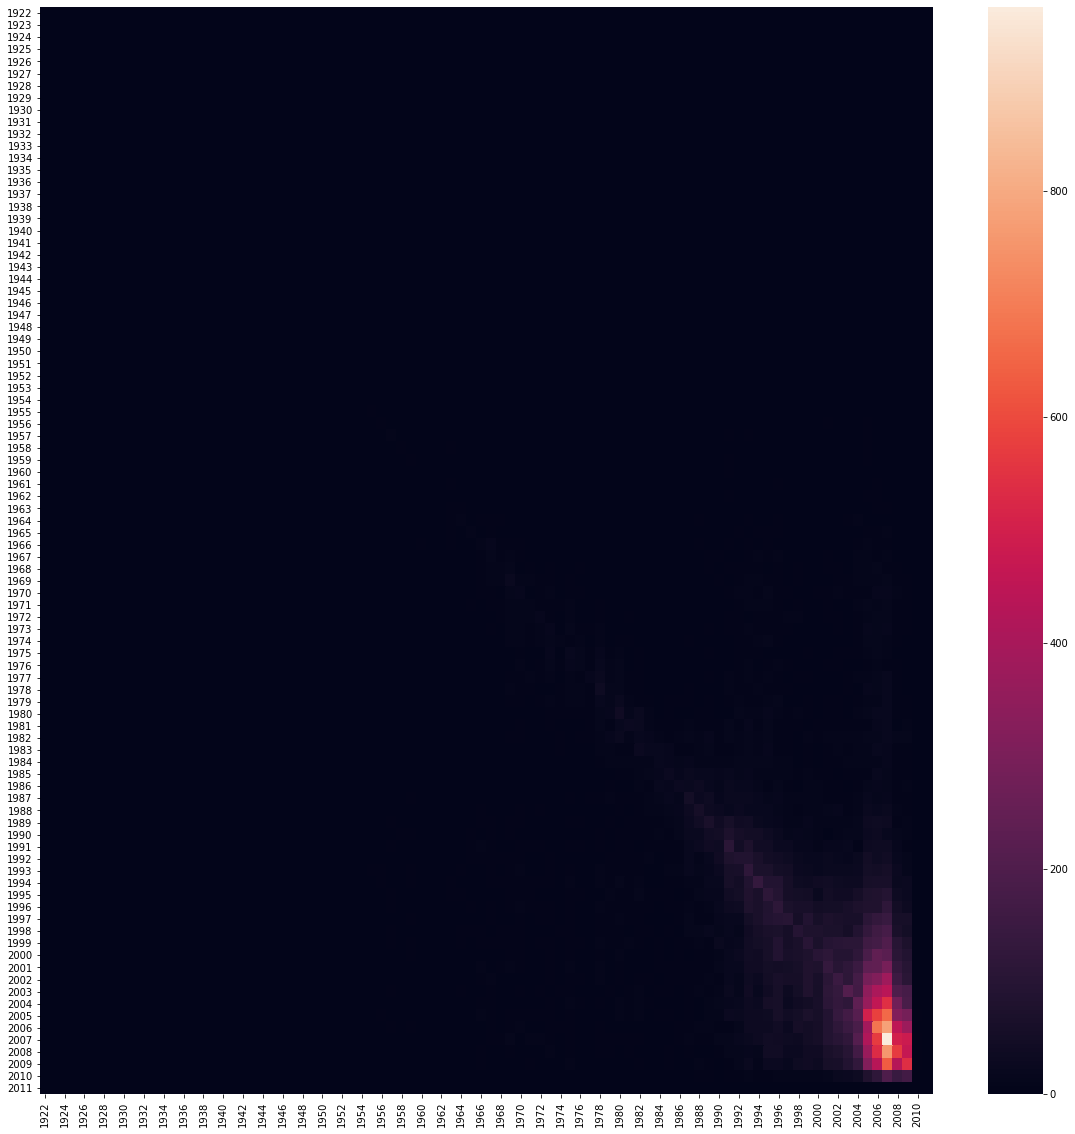

In [19]:
plt.figure(figsize = (20,20))
sn.heatmap(df_confmat)

In [21]:
accuracy_score(ydata.loc[round(0.9*data.shape[0]):], test_pred)

0.11163287086446104

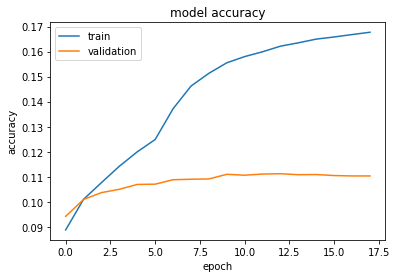

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

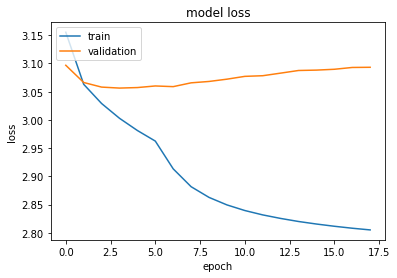

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

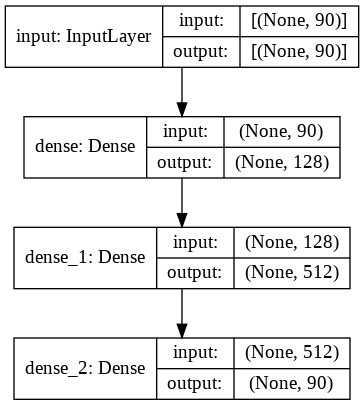

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 90)]              0         
_________________________________________________________________
dense (Dense)                (None, 128)               11648     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 90)                46170     
Total params: 123,866
Trainable params: 123,866
Non-trainable params: 0
_________________________________________________________________
